# DMs Guild Sales Analysis

This notebook analyzes sales data from DMs Guild, looking at trends, top performers, and revenue patterns.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.oauth2 import service_account
from googleapiclient.discovery import build

# Set style for better visualizations
plt.style.use('default')  # Use default style first
sns.set_theme()  # Apply seaborn styling
sns.set_palette("husl")  # Set color palette

In [3]:
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
from datetime import datetime

# named constant of spreadsheet name
SHEET_NAME = 'dms_guild_sales_testing'
# named constant indicating first possible year for sales data
START_YEAR = 2016
CURRENT_YEAR = datetime.now().year

def load_sheet_data(spreadsheet_id, credentials_path):
    # Authenticate and get credentials
    auth.authenticate_user()
    creds, _ = default()

    # Create client
    gc = gspread.authorize(creds)

    # Open spreadsheet and get worksheet
    spreadsheet = gc.open(SHEET_NAME)  # Replace with your sheet name
    worksheet = spreadsheet.sheet1  # Gets first sheet, or use get_worksheet(0)

    # 6. Convert to DataFrame
    df = pd.DataFrame(worksheet.get_all_records())

    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Units Sold'] = pd.to_numeric(df['Units Sold'], errors='coerce')
    df['Your Royalties'] = df['Your Royalties'].str.replace('$', '', regex=False)
    df['Your Royalties'] = pd.to_numeric(df['Your Royalties'], errors='coerce')

    return df

def data_quality_checks(df):
    # Check for valid months
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

    for value in df['Month']:
        if value not in months:
            raise ValueError(f"Invalid month value: {value}")

    #check for valid years
    for value in df['Year']:
        if value < START_YEAR or value > CURRENT_YEAR:
            raise ValueError(f"Invalid year value: {value}")

    # check for valid dm's guild titles - if reusing, hardcode with your own titles.
    titles = [
    "A DM's Guide to the Joy of Extradimensional Spaces",
    "Betrayal in the Hartsvale",
    "Dark Redemption",
    "DM's Guide to Dragon of Icespire Peak",
    "DM's Guide to Light of Xaryxis from the Spelljammer Campaign Setting",
    "DM's Guide to Turn of Fortune's Wheel, Part 1",
    "DM's Guide to Turn of Fortune's Wheel, Part 2",
    "DM's Guide to Turn of Fortune's Wheel, Part 3",
    "Ghosts of Saltmarsh Encounters",
    "Return to White Plume Mountain 5E Conversion",
    "The Mystery at Dreary's Well",
    "The Town of ManyAxes",
    "5e Conversion for Misplaced Spirit from the 2e Planecape Campaign Setting"
    ]

    for value in df['Title']:
        if value not in titles:
            raise ValueError(f"Invalid DM's Guild Title value: {value}")

     # Check for NaN values in Units Sold and Your Royalties
    if df['Units Sold'].isna().any():
        nan_rows = df[df['Units Sold'].isna()]
        raise ValueError(f"Found NaN values in Units Sold column:\n{nan_rows}")

    if df['Your Royalties'].isna().any():
        nan_rows = df[df['Your Royalties'].isna()]
        raise ValueError(f"Found NaN values in Your Royalties column:\n{nan_rows}")

    # Check for negative values in Units Sold and Your Royalties
    if (df['Units Sold'] < 0).any():
        neg_rows = df[df['Units Sold'] < 0]
        raise ValueError(f"Found negative values in Units Sold column:\n{neg_rows}")

    if (df['Your Royalties'] < 0).any():
        neg_rows = df[df['Your Royalties'] < 0]
        raise ValueError(f"Found negative values in Your Royalties column:\n{neg_rows}")



# Load and check the data
SPREADSHEET_ID = '1mtdp0DCDFWEVJPlb44MuNdqJnZCV9IDhPbFnDyj1G1Q'
CREDENTIALS_PATH = 'arctic-sign-398401-520cfea4d1ef.json'

# Load the data
df = load_sheet_data(SPREADSHEET_ID, CREDENTIALS_PATH)

data_quality_checks(df)

print("\nDataFrame Info:")
print(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 254 non-null    object 
 1   Year                  254 non-null    int64  
 2   Publisher             254 non-null    object 
 3   Title                 254 non-null    object 
 4   SKU                   254 non-null    object 
 5   Units Sold            254 non-null    int64  
 6   Net                   254 non-null    object 
 7   Current Royalty Rate  254 non-null    object 
 8   Your Royalties        254 non-null    float64
dtypes: float64(1), int64(2), object(6)
memory usage: 18.0+ KB
None


## Monthly Revenue Analysis

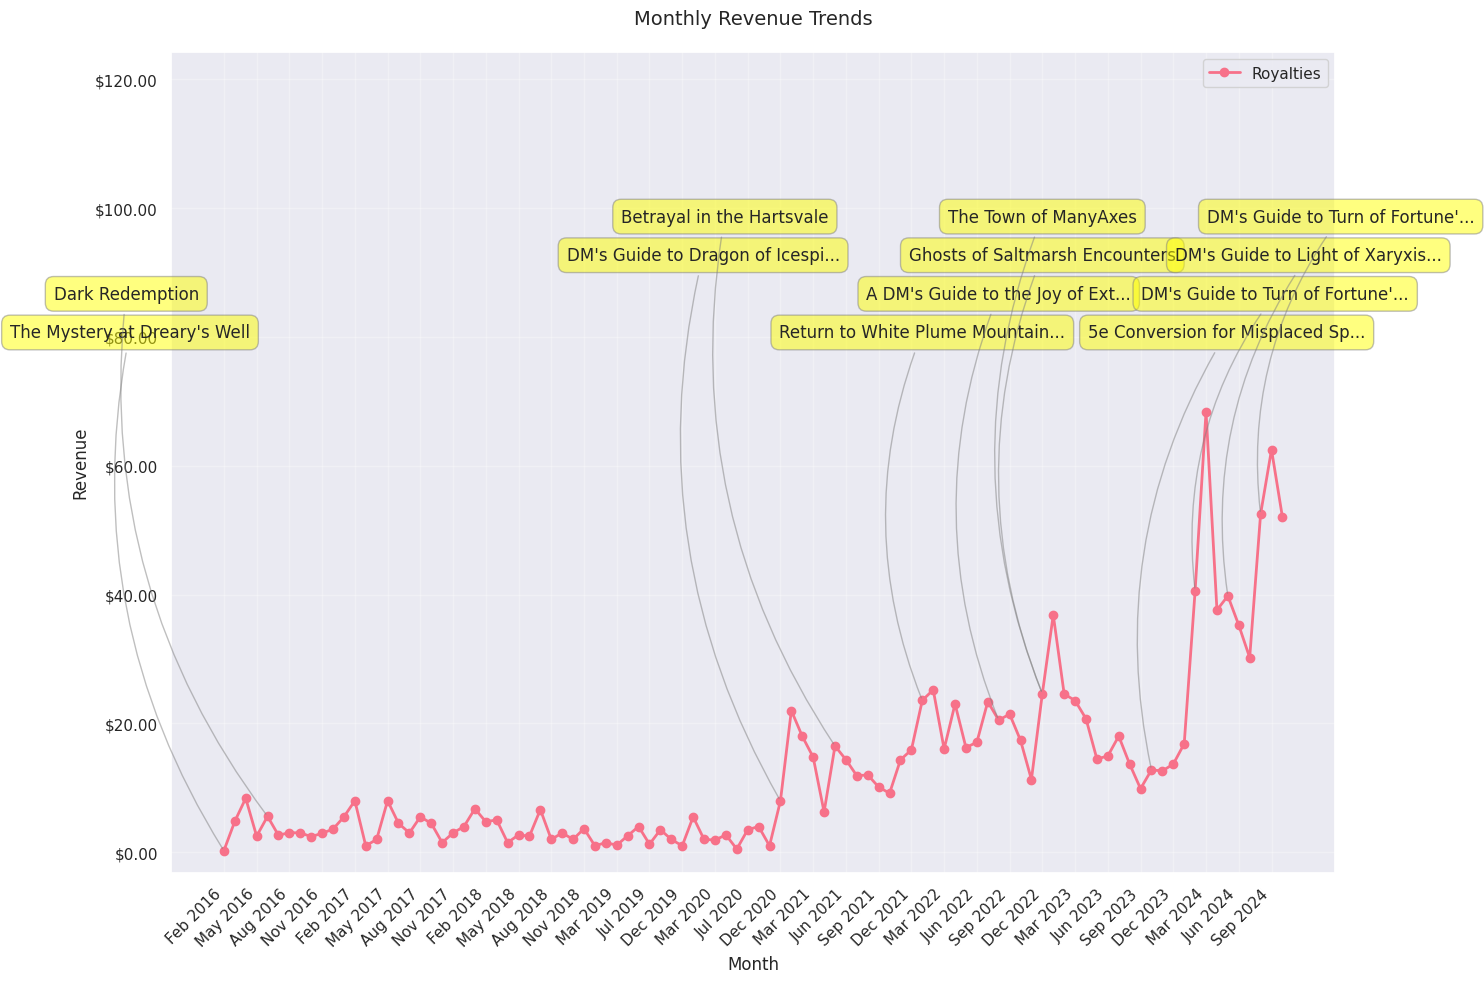

In [18]:
from math import ceil
# Create month-year combinations and convert to datetime for sorting
df['Month-Year'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str), format='%B %Y')

# Find first sale month for each title
first_sales = df[df['Units Sold'] > 0].groupby('Title')['Month-Year'].min().reset_index()
first_sales = first_sales.merge(df[['Month-Year', 'Title', 'Your Royalties', 'Units Sold']],
                               on=['Month-Year', 'Title'])

# Group by Month-Year and calculate totals
monthly_revenue = df.groupby('Month-Year').agg({
    'Your Royalties': 'sum',
    'Units Sold': 'sum'
}).reset_index()

# Sort by date
monthly_revenue = monthly_revenue.sort_values('Month-Year')

# Create formatted Month-Year string for plotting
monthly_revenue['Month-Year-Str'] = monthly_revenue['Month-Year'].dt.strftime('%b %Y')

# Plot monthly trends
plt.figure(figsize=(15, 10))

# Plot the main revenue line
plt.plot(range(len(monthly_revenue)), monthly_revenue['Your Royalties'],
         marker='o', label='Royalties', linewidth=2)

# Create x-axis labels - show only every 3rd month
x_ticks = range(len(monthly_revenue))
x_labels = monthly_revenue['Month-Year-Str']
shown_indices = x_ticks[::3]
shown_labels = x_labels[::3]

plt.xticks(shown_indices, shown_labels, rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.2f}'))

# Add labels and title
plt.title('Monthly Revenue Trends', pad=20, size=14)
plt.ylabel('Revenue', size=12)
plt.xlabel('Month', size=12)

# Calculate y-axis limits
y_min, y_max = plt.ylim()
y_range = y_max - y_min
plt.ylim(y_min, y_max + y_range * 0.7)  # Add more space at top for labels

# Sort first_sales by date for better label placement
first_sales_sorted = first_sales.sort_values('Month-Year')

# Calculate label positions with more spacing
num_labels = len(first_sales_sorted)
vertical_spacing = y_range * 0.08  # Increased spacing between labels
base_height = y_max + (y_range * 0.1)

# Create columns for labels to prevent overlap
num_columns = 3
labels_per_column = ceil(num_labels / num_columns)

for i, (_, row) in enumerate(first_sales_sorted.iterrows()):
    # Calculate column and position within column
    column = i // labels_per_column
    position_in_column = i % labels_per_column

    # Find x-position in data
    idx = monthly_revenue[monthly_revenue['Month-Year'] == row['Month-Year']].index[0]
    y_value = monthly_revenue.loc[idx, 'Your Royalties']

    # Calculate label position
    x_offset = (column - 1) * len(monthly_revenue) * 0.2  # Spread columns horizontally
    label_x = idx + x_offset
    label_y = base_height + (position_in_column * vertical_spacing)

    # Shorten title if needed
    short_title = row['Title'][:30] + '...' if len(row['Title']) > 30 else row['Title']

    # Add annotation with curved arrow
    plt.annotate(
        short_title,
        xy=(idx, y_value),  # Start at data point
        xytext=(label_x, label_y),  # Text position
        ha='center' if column == 1 else 'left' if column == 0 else 'right',
        va='bottom',
        bbox=dict(
            boxstyle='round,pad=0.5',
            fc='yellow',
            alpha=0.5,
            ec='gray'
        ),
        arrowprops=dict(
            arrowstyle='-',
            connectionstyle='arc3,rad=0.2',
            color='gray',
            alpha=0.5,
            linewidth=1
        )
    )

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Top Performing Products

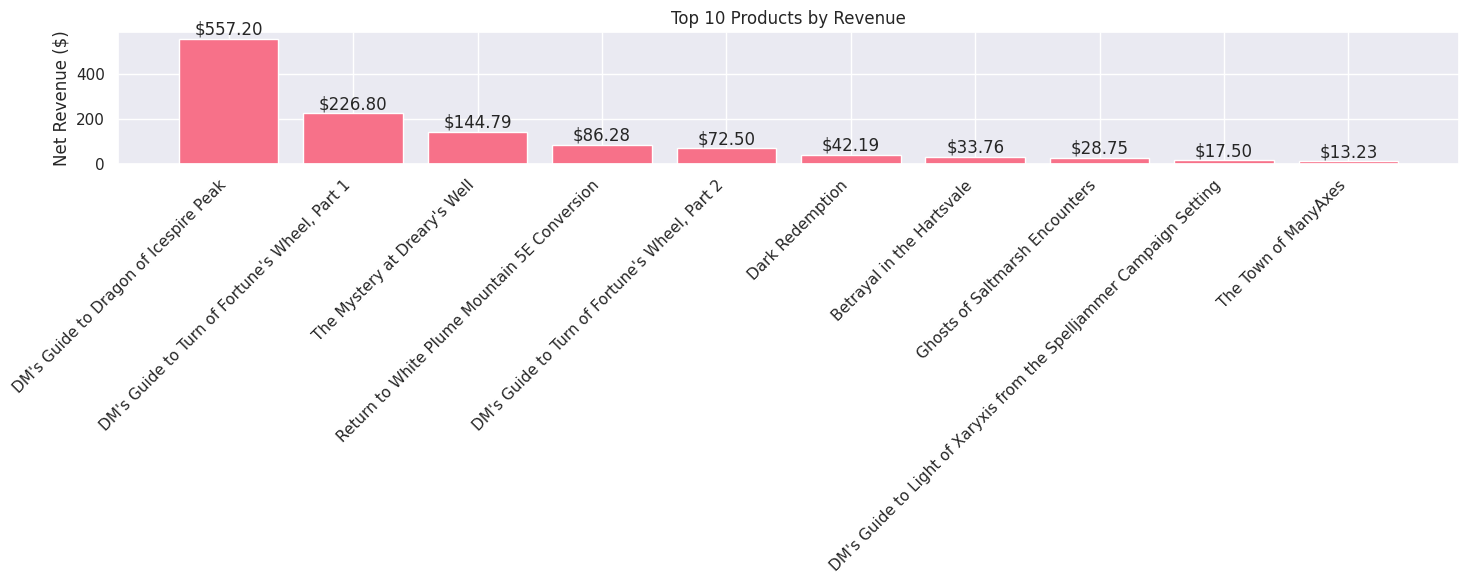


Top 10 Products Details:
                                                               Title  Units Sold  Your Royalties
                               DM's Guide to Dragon of Icespire Peak        1027          557.20
                       DM's Guide to Turn of Fortune's Wheel, Part 1         156          226.80
                                        The Mystery at Dreary's Well         170          144.79
                        Return to White Plume Mountain 5E Conversion          40           86.28
                       DM's Guide to Turn of Fortune's Wheel, Part 2          29           72.50
                                                     Dark Redemption          86           42.19
                                           Betrayal in the Hartsvale          23           33.76
                                      Ghosts of Saltmarsh Encounters          61           28.75
DM's Guide to Light of Xaryxis from the Spelljammer Campaign Setting           7           17.50
    

In [19]:
# Aggregate by product
product_performance = df.groupby('Title').agg({
    'Units Sold': 'sum',
    'Your Royalties': 'sum'
}).reset_index()

# Sort by revenue and get top 10
top_10_products = product_performance.nlargest(10, 'Your Royalties')

# Create bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(top_10_products)), top_10_products['Your Royalties'])
plt.title('Top 10 Products by Revenue')
plt.xticks(range(len(top_10_products)), top_10_products['Title'], rotation=45, ha='right')
plt.ylabel('Net Revenue ($)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed stats for top products
print("\nTop 10 Products Details:")
print(top_10_products.to_string(index=False))

## Year-over-Year Comparison

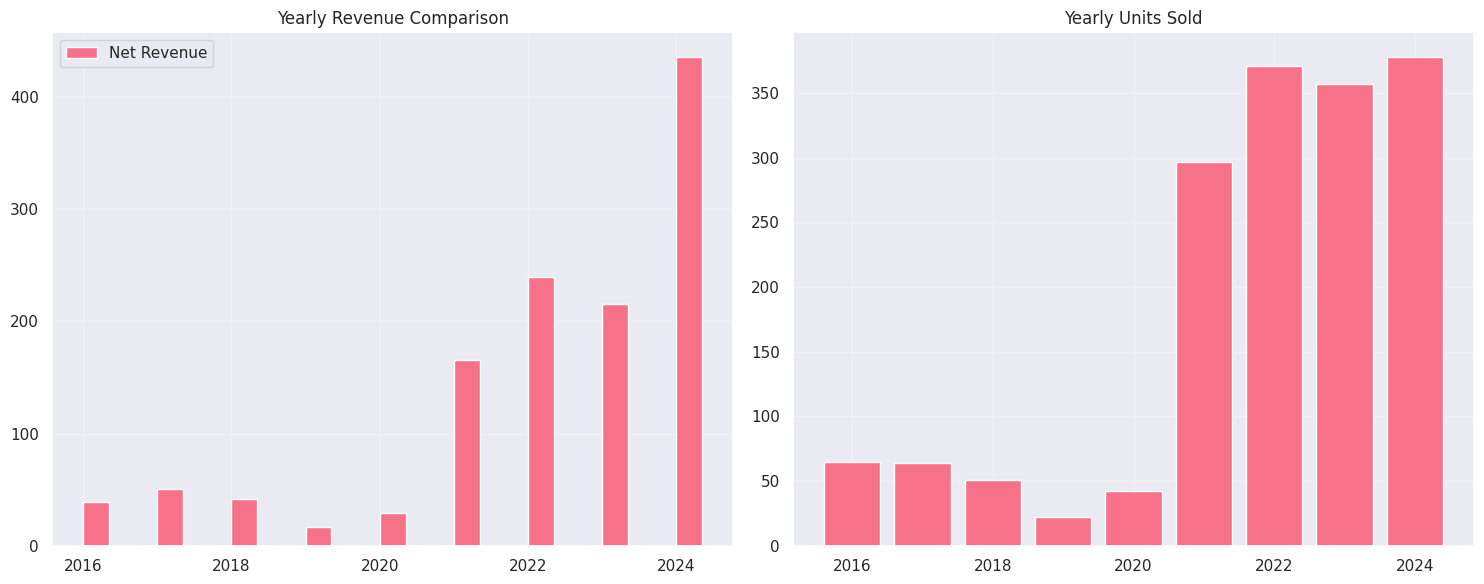


Year-over-Year Growth:
   Year  Your Royalties  Units Sold  Revenue_Growth  Units_Growth
0  2016           39.20          65             NaN           NaN
1  2017           50.50          64           28.83         -1.54
2  2018           41.52          51          -17.78        -20.31
3  2019           16.91          22          -59.27        -56.86
4  2020           29.09          42           72.03         90.91
5  2021          165.33         297          468.34        607.14
6  2022          239.83         371           45.06         24.92
7  2023          215.83         357          -10.01         -3.77
8  2024          435.74         378          101.89          5.88


In [20]:
# Calculate yearly totals
yearly_totals = df.groupby('Year').agg({
    'Your Royalties': 'sum',
    'Units Sold': 'sum'
}).reset_index()

# Create year-over-year comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Revenue comparison
width = 0.35
ax1.bar(yearly_totals['Year'] + width/2, yearly_totals['Your Royalties'], width, label='Net Revenue')
ax1.set_title('Yearly Revenue Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Units sold comparison
ax2.bar(yearly_totals['Year'], yearly_totals['Units Sold'])
ax2.set_title('Yearly Units Sold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print year-over-year growth
print("\nYear-over-Year Growth:")
yearly_growth = yearly_totals.copy()
yearly_growth['Revenue_Growth'] = yearly_growth['Your Royalties'].pct_change() * 100
yearly_growth['Units_Growth'] = yearly_growth['Units Sold'].pct_change() * 100
print(yearly_growth.round(2))

# Revenue Per Month Avalable

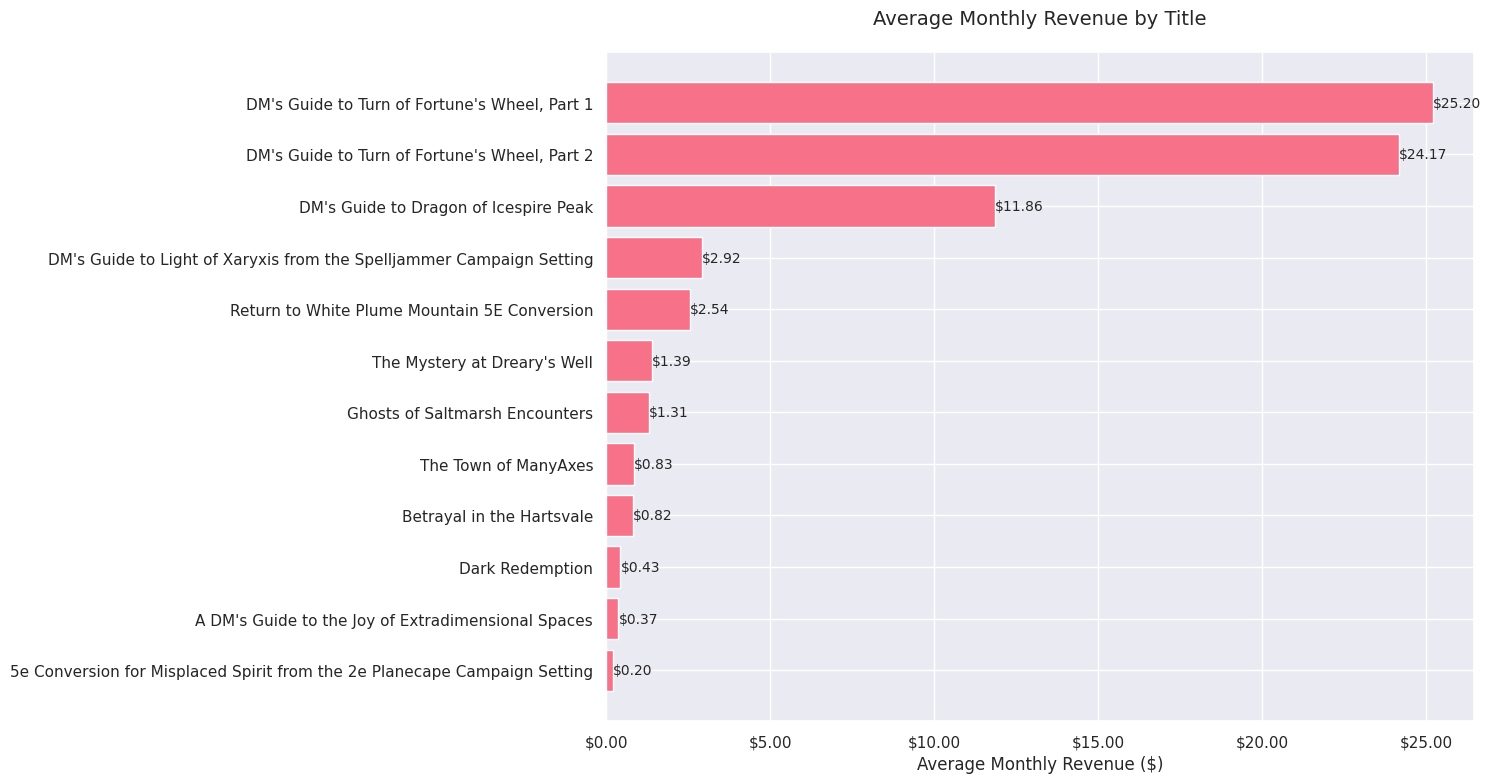


Detailed Title Revenue Analysis:
----------------------------------------------------------------------------------------------------
Title: The Mystery at Dreary's Well
First Sale: February 2016
Months Available: 104
Total Revenue: $144.79
Average Monthly Revenue: $1.39
Revenue Per Unit: $0.85
Total Units Sold: 170
----------------------------------------------------------------------------------------------------
Title: Dark Redemption
First Sale: June 2016
Months Available: 98
Total Revenue: $42.19
Average Monthly Revenue: $0.43
Revenue Per Unit: $0.49
Total Units Sold: 86
----------------------------------------------------------------------------------------------------
Title: DM's Guide to Dragon of Icespire Peak
First Sale: December 2020
Months Available: 47
Total Revenue: $557.20
Average Monthly Revenue: $11.86
Revenue Per Unit: $0.54
Total Units Sold: 1,027
----------------------------------------------------------------------------------------------------
Title: Betrayal in 

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime

def analyze_title_revenue(df):
    """
    Analyzes title revenue based on months available and calculates average monthly revenue.

    Parameters:
    df (pandas.DataFrame): DataFrame with columns: Title, Month, Year, Your Royalties, Units Sold

    Returns:
    pandas.DataFrame: Analysis results per title
    pandas.DataFrame: Monthly performance metrics
    """
    # Ensure Month-Year column exists
    if 'Month-Year' not in df.columns:
        df['Month-Year'] = pd.to_datetime(df['Month'] + ' ' + df['Year'].astype(str), format='%B %Y')

    # Find first and last sale dates for each title
    title_spans = df.groupby('Title').agg({
        'Month-Year': ['min', 'max']
    }).reset_index()
    title_spans.columns = ['Title', 'First_Sale', 'Last_Sale']


    # Calculate months available for each title
    # Calculate months available for each title
    # Using year and month differences to get accurate month count
    title_spans['Months_Available'] = (
        (title_spans['Last_Sale'].dt.year - title_spans['First_Sale'].dt.year) * 12 +
        (title_spans['Last_Sale'].dt.month - title_spans['First_Sale'].dt.month) + 1
    )

    # Calculate total revenue for each title
    title_revenue = df.groupby('Title').agg({
        'Your Royalties': 'sum',
        'Units Sold': 'sum'
    }).reset_index()

    # Merge spans and revenue
    title_analysis = pd.merge(title_spans, title_revenue, on='Title')

    # Calculate average monthly revenue
    title_analysis['Avg_Monthly_Revenue'] = (title_analysis['Your Royalties'] /
                                           title_analysis['Months_Available']).round(2)

    # Calculate revenue per unit
    title_analysis['Revenue_Per_Unit'] = (title_analysis['Your Royalties'] /
                                         title_analysis['Units Sold']).round(2)

    # Sort by average monthly revenue
    title_analysis = title_analysis.sort_values('Avg_Monthly_Revenue', ascending=False)

    # Calculate monthly performance metrics
    monthly_metrics = df.groupby('Month-Year').agg({
        'Your Royalties': 'sum',
        'Units Sold': 'sum'
    }).reset_index()

    # Calculate running averages
    monthly_metrics['Cumulative_Avg_Revenue'] = (monthly_metrics['Your Royalties'].cumsum() /
                                               (range(1, len(monthly_metrics) + 1)))

    # Calculate month-over-month growth
    monthly_metrics['Revenue_MoM_Growth'] = monthly_metrics['Your Royalties'].pct_change() * 100

    # Sort both DataFrames by date
    monthly_metrics = monthly_metrics.sort_values('Month-Year')
    title_analysis = title_analysis.sort_values('First_Sale')

    return title_analysis, monthly_metrics

def print_title_analysis(title_analysis):
    """
    Prints a formatted analysis report for each title and displays a bar chart of average monthly revenue.
    """
    # Create the bar chart
    plt.figure(figsize=(15, 8))

    # Sort by average monthly revenue descending
    plot_data = title_analysis.sort_values('Avg_Monthly_Revenue', ascending=True)  # Ascending for bottom-to-top

    # Create bars
    bars = plt.barh(plot_data['Title'], plot_data['Avg_Monthly_Revenue'])

    # Add value labels on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'${width:,.2f}',
                va='center', ha='left', fontsize=10)

    # Customize the chart
    plt.title('Average Monthly Revenue by Title', pad=20, size=14)
    plt.xlabel('Average Monthly Revenue ($)', size=12)

    # Format x-axis with dollar signs
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.2f}'))

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print detailed analysis
    print("\nDetailed Title Revenue Analysis:")
    print("-" * 100)
    for _, row in title_analysis.iterrows():
        print(f"Title: {row['Title']}")
        print(f"First Sale: {row['First_Sale'].strftime('%B %Y')}")
        print(f"Months Available: {row['Months_Available']}")
        print(f"Total Revenue: ${row['Your Royalties']:,.2f}")
        print(f"Average Monthly Revenue: ${row['Avg_Monthly_Revenue']:,.2f}")
        print(f"Revenue Per Unit: ${row['Revenue_Per_Unit']:,.2f}")
        print(f"Total Units Sold: {row['Units Sold']:,}")
        print("-" * 100)

# Run the analysis
title_analysis, monthly_metrics = analyze_title_revenue(df)

# Print the detailed analysis
print_title_analysis(title_analysis)

# You can also access specific metrics, for example:
# print("\nTop 5 titles by average monthly revenue:")
# print(title_analysis[['Title', 'Avg_Monthly_Revenue']].head().to_string(index=False))

# Total Sales and Medal counts

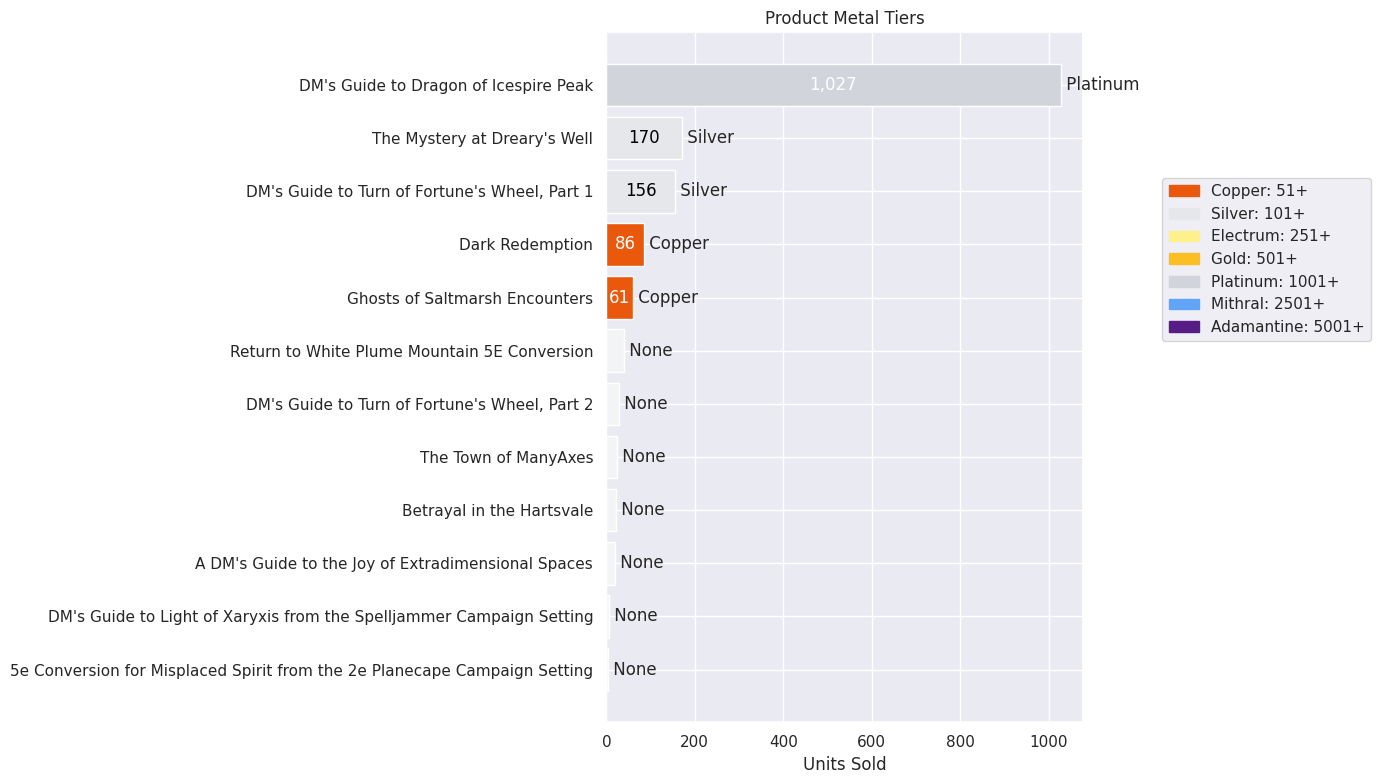

In [14]:
import matplotlib.pyplot as plt

# Aggregate by product
product_performance = df.groupby('Title').agg({
    'Units Sold': 'sum',
    'Your Royalties': 'sum'
}).reset_index()



def get_metal_tier(units):
    if units >= 5001: return 'Adamantine', '#581c87'  # purple-900
    if units >= 2501: return 'Mithral', '#60a5fa'     # blue-400
    if units >= 1001: return 'Platinum', '#d1d5db'    # gray-300
    if units >= 501: return 'Gold', '#fbbf24'         # yellow-400
    if units >= 251: return 'Electrum', '#fef08a'     # yellow-200
    if units >= 101: return 'Silver', '#e5e7eb'       # gray-200
    if units >= 51: return 'Copper', '#ea580c'        # orange-600
    return 'None', '#f3f4f6'                          # gray-100

# Add metal tier info
product_performance['Tier'], product_performance['Color'] = zip(*product_performance['Units Sold'].map(get_metal_tier))

# Sort by units sold
df_sorted = product_performance.sort_values('Units Sold', ascending=True)

# Create horizontal bar chart
plt.figure(figsize=(15, max(8, len(df_sorted) * 0.4)))
bars = plt.barh(df_sorted['Title'], df_sorted['Units Sold'],
                color=df_sorted['Color'])

# Add tier labels
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f" {df_sorted['Tier'].iloc[i]}",
             va='center')

plt.title('Product Metal Tiers')
plt.xlabel('Units Sold')

# Add units sold label inside bars for products with 50+ units
for i, bar in enumerate(bars):
   units = df_sorted['Units Sold'].iloc[i]
   if units >= 50:
       plt.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
               f'{int(units):,}',
               va='center',
               ha='center',
               color='black' if df_sorted['Tier'].iloc[i] in ['Silver','Electrum'] else 'white')

# Add legend for thresholds
thresholds = [
    ('Copper', 51, '#ea580c'),
    ('Silver', 101, '#e5e7eb'),
    ('Electrum', 251, '#fef08a'),
    ('Gold', 501, '#fbbf24'),
    ('Platinum', 1001, '#d1d5db'),
    ('Mithral', 2501, '#60a5fa'),
    ('Adamantine', 5001, '#581c87')
]

legend_elements = [plt.Rectangle((0,0),1,1, color=color, label=f'{tier}: {threshold}+')
                  for tier, threshold, color in thresholds]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.15,.8), loc='upper left')

plt.tight_layout()
plt.show()


# Forecasting Future Sales


Trying exp_trend method:


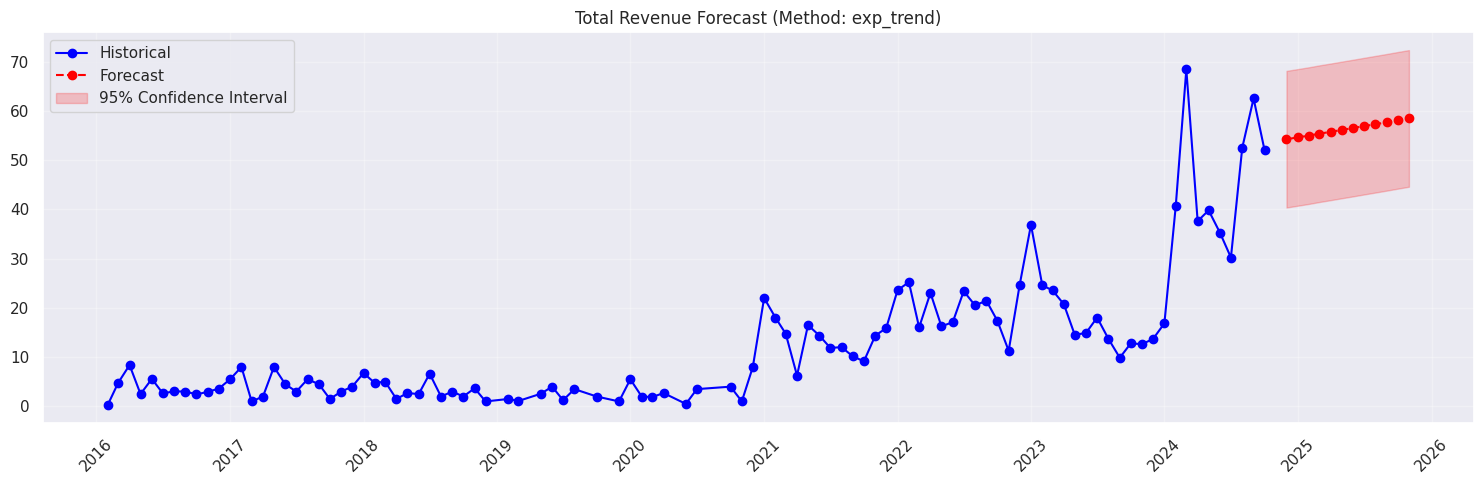


Forecast Summary:
Total Projected Revenue: $675.84
Average Monthly Revenue: $56.32
Range: $54.23 - $58.46


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from scipy import stats

def create_sales_forecast(df, forecast_months=12, method='exp_trend'):
    """
    Creates sales forecasts using various forecasting methods.

    Parameters:
    df: DataFrame with columns Month-Year and Your Royalties
    forecast_months: Number of months to forecast (default 12)
    method: Forecasting method ('exp_trend', 'exp_growth', 'linear')

    Returns:
    DataFrame with forecasts and visualization
    """
    try:
        # Aggregate total monthly sales
        monthly_sales = df.groupby('Month-Year')['Your Royalties'].sum().reset_index()
        monthly_sales = monthly_sales.sort_values('Month-Year')

        if len(monthly_sales) < 4:
            raise ValueError("Need at least 4 months of historical data")

        sales_data = monthly_sales['Your Royalties'].values

        if method == 'exp_trend':
            # Exponential smoothing with multiplicative trend
            model = ExponentialSmoothing(
                sales_data,
                trend='mul',
                damped_trend=False
            ).fit(optimized=True)
            forecast = model.forecast(forecast_months)

        elif method == 'exp_growth':
            # Exponential growth model
            x = np.arange(len(sales_data))
            y = np.log(sales_data + 1)  # Add 1 to handle zeros
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

            future_x = np.arange(len(sales_data), len(sales_data) + forecast_months)
            log_forecast = slope * future_x + intercept
            forecast = np.exp(log_forecast) - 1

        elif method == 'linear':
            # Linear regression with recent trend weight
            x = np.arange(len(sales_data))
            weights = np.exp(0.1 * x)  # Exponential weights for recent data
            slope, intercept = np.polyfit(x, sales_data, 1, w=weights)

            future_x = np.arange(len(sales_data), len(sales_data) + forecast_months)
            forecast = slope * future_x + intercept

        # Ensure no negative values
        forecast = np.maximum(forecast, 0)

        # Create future dates
        last_date = monthly_sales['Month-Year'].max()
        future_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=forecast_months,
            freq='ME'
        )

        # Plot results
        plt.figure(figsize=(15, 5))
        plt.title(f'Total Revenue Forecast (Method: {method})')

        # Plot historical data
        plt.plot(monthly_sales['Month-Year'], sales_data,
                label='Historical', color='blue', marker='o')

        # Plot forecast
        plt.plot(future_dates, forecast,
                label='Forecast', color='red', linestyle='--', marker='o')

        # Add confidence intervals for exp_trend method
        if method == 'exp_trend':
            mse = mean_squared_error(sales_data, model.fittedvalues)
            std_dev = np.sqrt(mse)
            plt.fill_between(future_dates,
                            forecast - 2*std_dev,
                            forecast + 2*std_dev,
                            color='red', alpha=0.2,
                            label='95% Confidence Interval')

        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Create output DataFrame
        results = []

        # Add historical data
        for date, value in zip(monthly_sales['Month-Year'], sales_data):
            results.append({
                'Month-Year': date,
                'Revenue': value,
                'Type': 'Historical'
            })

        # Add forecast data
        for date, value in zip(future_dates, forecast):
            results.append({
                'Month-Year': date,
                'Revenue': value,
                'Type': 'Forecast'
            })

        forecast_df = pd.DataFrame(results)

        # Print summary statistics
        forecast_values = forecast_df[forecast_df['Type'] == 'Forecast']['Revenue']
        print("\nForecast Summary:")
        print(f"Total Projected Revenue: ${forecast_values.sum():,.2f}")
        print(f"Average Monthly Revenue: ${forecast_values.mean():,.2f}")
        print(f"Range: ${forecast_values.min():,.2f} - ${forecast_values.max():,.2f}")

        return forecast_df

    except Exception as e:
        print(f"Error creating forecast: {str(e)}")
        return None


# Try different forecasting methods
# methods = ['exp_trend', 'exp_growth', 'linear']
methods = ['exp_trend']
for method in methods:
    print(f"\nTrying {method} method:")
    forecast_results = create_sales_forecast(df, method=method)